# YOLO -> HS -> YOLO pipeline 

In [4]:
# imports
import os
from pathlib import Path
import pandas as pd

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image

import warnings
warnings.filterwarnings("ignore")
from ultralytics import YOLO, checks
import torch
checks()
import matlab.engine


run pre-trained YOLO model

In [46]:

# Correct path to the trained weights
model = YOLO(r"yolov8m-drone.pt")

# Path to testing folder
test_images_dir = r"output_images\test"  # Folder containing test images
results_output_dir = "YOLO_test_results"  # Directory to save results
os.makedirs(results_output_dir, exist_ok=True)

# Run YOLO on the testing folder
results = model.predict(
    source=test_images_dir,  # Path to test images
    save=True,               # Save annotated images
    save_txt=True,           # Save predictions in text format
    project=results_output_dir,  # Save results in this folder
    imgsz=640                # Image size
)

# Print summary of results
print("Summary of Detection Results:")
print(f"Number of images tested: {len(results)}")
print(f"Results saved in: {results_output_dir}")

# Display per-image metrics
for result in results:
    print(f"Image: {result.path}, Detections: {len(result.boxes)}")



image 1/491 C:\Users\michael\Desktop\f_proj\output_images\test\10.jpg: 480x640 1 0, 24.6ms
image 2/491 C:\Users\michael\Desktop\f_proj\output_images\test\1030.jpg: 480x640 (no detections), 24.5ms
image 3/491 C:\Users\michael\Desktop\f_proj\output_images\test\1031.jpg: 480x640 (no detections), 24.9ms
image 4/491 C:\Users\michael\Desktop\f_proj\output_images\test\1032.jpg: 480x640 (no detections), 20.4ms
image 5/491 C:\Users\michael\Desktop\f_proj\output_images\test\1037.jpg: 480x640 (no detections), 18.0ms
image 6/491 C:\Users\michael\Desktop\f_proj\output_images\test\1038.jpg: 480x640 (no detections), 18.0ms
image 7/491 C:\Users\michael\Desktop\f_proj\output_images\test\1039.jpg: 480x640 (no detections), 17.0ms
image 8/491 C:\Users\michael\Desktop\f_proj\output_images\test\1040.jpg: 480x640 1 0, 17.5ms
image 9/491 C:\Users\michael\Desktop\f_proj\output_images\test\1041.jpg: 480x640 1 0, 1 1, 18.0ms
image 10/491 C:\Users\michael\Desktop\f_proj\output_images\test\1058.jpg: 480x640 1 0, 

converts image to HS and detects anomalies in it.

In [2]:


def detect_anomalies(image_path, dictionary_path='hs_dictionaries.mat', numb_pca_components =4,num_ica_components = 4, ICA_max_iterations = 1000, similarity_threshold = 1, opts_lambda = 0.4, opts_max_iter = 100, lambda_ = 0.01, overlap_threshold = 0.2, min_area = 50,max_area=3200, min_anomalous_pixels = 20):
    # Start MATLAB engine
    eng = matlab.engine.start_matlab()

    # Convert RGB to hyperspectral using matlab code
    rec_hs = eng.convertToHyperspectral(image_path, dictionary_path)

    # Perform anomaly detection using matlab code
    bounding_boxes = eng.anomalyDetection(
        rec_hs,
        numb_pca_components,
        num_ica_components,
        ICA_max_iterations,
        similarity_threshold,
        opts_lambda,
        opts_max_iter,
        lambda_,
        overlap_threshold,
        min_area,
        max_area,
        min_anomalous_pixels
        
    )
    # Convert MATLAB bounding boxes to Python list
    bounding_boxes = [list(bbox) for bbox in bounding_boxes]

    return bounding_boxes


In [25]:
# used to restart matlab API in case of changes in the functions
eng = matlab.engine.start_matlab()
eng.quit()

merging close and overlapping bounding boxes

In [5]:
def merge_bounding_boxes(bboxes, proximity_threshold=5):
    def are_boxes_close_or_overlapping(box1, box2, threshold):
        x1_min, y1_min, x1_max, y1_max = box1
        x2_min, y2_min, x2_max, y2_max = box2

        # Check if boxes overlap or are within proximity threshold
        return not (
            x1_max + threshold < x2_min or x2_max + threshold < x1_min or
            y1_max + threshold < y2_min or y2_max + threshold < y1_min
        )

    # Convert [x, y, w, h] to [x_min, y_min, x_max, y_max]
    bboxes = [[x, y, x + w, y + h] for x, y, w, h in bboxes]

    def merge_boxes(box1, box2):
        x1_min, y1_min, x1_max, y1_max = box1
        x2_min, y2_min, x2_max, y2_max = box2
        return [
            min(x1_min, x2_min),
            min(y1_min, y2_min),
            max(x1_max, x2_max),
            max(y1_max, y2_max),
        ]

    # Iteratively merge bounding boxes
    merged = True
    while merged:
        merged = False
        new_bboxes = []

        while bboxes:
            base_box = bboxes.pop(0)

            for other_box in bboxes[:]:
                if are_boxes_close_or_overlapping(base_box, other_box, proximity_threshold):
                    base_box = merge_boxes(base_box, other_box)
                    bboxes.remove(other_box)
                    merged = True

            new_bboxes.append(base_box)

        bboxes = new_bboxes

    # Convert back to [x, y, w, h]
    bboxes = [[x_min, y_min, x_max - x_min, y_max - y_min] for x_min, y_min, x_max, y_max in bboxes]
    return bboxes


combined pipeline

In [80]:
from ultralytics import YOLO
import os
import cv2


# Load the YOLO model
model = YOLO(r"yolov8m-drone.pt")

# Path to testing folder
test_images_dir = r"output_images\test"  # Folder containing test images
results_output_dir = "test_results_HS"  # Directory to save results
os.makedirs(results_output_dir, exist_ok=True)
labels_output_dir = os.path.join(results_output_dir, "labels")
os.makedirs(labels_output_dir, exist_ok=True)
# Run YOLO on each image
test_images = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir)]
for image_path in test_images:
    print(f"Processing: {image_path}")

    # Run YOLO on the image
    results = model.predict(source=image_path, imgsz=640, save=False)
    yolo_labels = []
    # Check if YOLO detected any drones
    detections = results[0].boxes  # Access detections for the first image

    if detections is None or len(detections) == 0 :
        print(f"No anomalies detected in {image_path}. Running anomaly detection pipeline...")
        try:
            # Run anomaly detection to get bounding boxes (using HS conversion)
            
            bounding_boxes = detect_anomalies(image_path,max_area = 30000, numb_pca_components=2 )  # pipeline to matlab, returns bounding boxes. parameter optimization needed
            merged_boxes = merge_bounding_boxes(bounding_boxes, proximity_threshold=20)
            merged_boxes = merge_bounding_boxes(merged_boxes, proximity_threshold=20)
            # Load the original image
            original_image = cv2.imread(image_path)

            # Run YOLO on each anomaly bounding box
            for bbox in merged_boxes:
                x, y, w, h = map(int, bbox)

                # Add padding to the bounding box (needs adjusting)
                padding = 50
                x = max(x - padding, 0)
                y = max(y - padding, 0)
                w = min(w + 2 * padding, original_image.shape[1] - x)
                h = min(h + 2 * padding, original_image.shape[0] - y)

                # Extract ROI from the original image
                roi = original_image[y:y+h, x:x+w]

                # Resize the ROI to match YOLO's input size
                yolo_input_size = (640, 640)  # Adjust based on your YOLO model
                roi_resized = cv2.resize(roi, yolo_input_size)

                # Run YOLO on the ROI
                roi_results = model.predict(source=roi_resized)

                # Check for drone detections in the ROI
                roi_detections = roi_results[0].boxes
                if roi_detections is not None and len(roi_detections) > 0:
                    print(f"Anomaly detected in ROI from {image_path}!")

                    # Map ROI detections back to the original image
                    for roi_box in roi_detections:
                        # YOLOv8 format: box.xyxy (coordinates), box.conf (confidence), box.cls (class ID)
                        x1, y1, x2, y2 = map(int, roi_box.xyxy[0])
                        confidence = float(roi_box.conf[0])
                        class_id = int(roi_box.cls[0])
                        for roi_box in roi_detections:
                            # YOLOv8 format: box.xyxy (coordinates), box.conf (confidence), box.cls (class ID)
                            x1, y1, x2, y2 = map(int, roi_box.xyxy[0])
                            confidence = float(roi_box.conf[0])
                            class_id = int(roi_box.cls[0])

                            # Print the detection details (for debugging)
                            print(f"Detected object: Class ID - {class_id}, Confidence - {confidence:.2f}, Bounding Box - x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")
                            
                        if class_id == 0:  # Drone class ID - 0, brids - 1
                            print(f"Drone detected with confidence {confidence:.2f} in ROI ({x}, {y}, {w}, {h}).")

                            x1 = x1 * w // yolo_input_size[0] + x
                            x2 = x2 * w // yolo_input_size[0] + x
                            y1 = y1 * h // yolo_input_size[1] + y
                            y2 = y2 * h // yolo_input_size[1] + y

                            # Save bounding box in YOLO format for metrics calculation
                            x_center = (x1 + x2) / 2 / original_image.shape[1]
                            y_center = (y1 + y2) / 2 / original_image.shape[0]
                            bbox_width = (x2 - x1) / original_image.shape[1]
                            bbox_height = (y2 - y1) / original_image.shape[0]
                            
                            yolo_labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}")

                            
                            # Draw the bounding box on the original image
                            cv2.rectangle(
                                original_image,
                                (x1, y1),
                                (x2, y2),
                                color=(0, 255, 0),  # Green color for detected anomalies
                                thickness=2
                            )

            # Save the updated image with bounding boxes
            output_path = os.path.join(results_output_dir, os.path.basename(image_path))
            cv2.imwrite(output_path, cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))

            label_path = os.path.join(labels_output_dir, os.path.splitext(os.path.basename(image_path))[0] + ".txt")
            print(yolo_labels)
            with open(label_path, "w") as f:
                f.write("\n".join(yolo_labels))

        except Exception as e:
            print(f"An error occurred while processing anomalies for {image_path}: {e}")
            continue  # Skip to the next image in case of error in matlab code


    else:
        print(f"Drones detected in {image_path}. Skipping pipeline...")

        # Save YOLO detections for the image
        annotated_image_path = os.path.join(results_output_dir, os.path.basename(image_path))
        results[0].save(annotated_image_path)
        original_image = cv2.imread(image_path)

        label_path = os.path.join(labels_output_dir, os.path.splitext(os.path.basename(image_path))[0] + ".txt")
        with open(label_path, "w") as f:
            for box in results[0].boxes:
                x_center, y_center, width, height = box.xywh[0]
                class_id = int(box.cls[0])

                x_center /= original_image.shape[1]
                y_center /= original_image.shape[0]
                width /=  original_image.shape[1]
                height /= original_image.shape[0]
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


print("\nPipeline completed.")


Processing: C:\Users\michael\Desktop\f_proj\output_images\test\10.jpg

image 1/1 C:\Users\michael\Desktop\f_proj\output_images\test\10.jpg: 480x640 1 0, 26.0ms
Speed: 1.0ms preprocess, 26.0ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)
Drones detected in C:\Users\michael\Desktop\f_proj\output_images\test\10.jpg. Skipping pipeline...
Processing: C:\Users\michael\Desktop\f_proj\output_images\test\1030.jpg

image 1/1 C:\Users\michael\Desktop\f_proj\output_images\test\1030.jpg: 480x640 (no detections), 22.9ms
Speed: 1.0ms preprocess, 22.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
No drones detected in C:\Users\michael\Desktop\f_proj\output_images\test\1030.jpg. Running anomaly detection pipeline...

0: 640x640 (no detections), 132.7ms
Speed: 3.0ms preprocess, 132.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
[]
Processing: C:\Users\michael\Desktop\f_proj\output_images\test\1031.jpg

image 1/1 C:\Users\michael\Desktop\f_pr

evals

# Metric comparison

Metrics total - for the entire dataset

In [10]:
import os
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def load_yolo_labels(label_folder, normalize=False, img_width=480, img_height=640):
    """
    Load YOLO-format labels from a folder and optionally normalize the bounding boxes.
    
    Args:
        label_folder (str): Path to the folder containing YOLO labels.
        normalize (bool): Whether to normalize bounding boxes.
        img_width (int): Image width (used for normalization).
        img_height (int): Image height (used for normalization).
        
    Returns:
        dict: Dictionary with image names as keys and list of bounding boxes as values.
    """
    labels = {}
    for label_file in Path(label_folder).glob("*.txt"):
        image_name = label_file.stem
        with open(label_file, "r") as f:
            bboxes = []
            for line in f:
                parts = line.strip().split()
                class_id, x_center, y_center, width, height = map(float, parts)
                
                if  (x_center > 1 or y_center > 1 or width > 1 or height > 1):
                    x_center /= img_width
                    y_center /= img_height
                    width /= img_width
                    height /= img_height
                    print(x_center, y_center, width, height)
                bboxes.append([class_id, x_center, y_center, width, height])
                
            labels[image_name] = bboxes
    return labels

def yolo_to_xyxy(bbox, img_width, img_height):
    """
    Convert YOLO bbox format (x_center, y_center, width, height) to (x_min, y_min, x_max, y_max).
    
    Args:
        bbox (list): YOLO bounding box [x_center, y_center, width, height].
        img_width (int): Image width.
        img_height (int): Image height.
        
    Returns:
        list: Bounding box in (x_min, y_min, x_max, y_max) format.
    """
    x_center, y_center, width, height = bbox[1:]
    x_min = (x_center - width / 2) * img_width
    y_min = (y_center - height / 2) * img_height
    x_max = (x_center + width / 2) * img_width
    y_max = (y_center + height / 2) * img_height
    return [x_min, y_min, x_max, y_max]

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    
    Args:
        box1 (list): Bounding box [x_min, y_min, x_max, y_max].
        box2 (list): Bounding box [x_min, y_min, x_max, y_max].
        
    Returns:
        float: IoU value.
    """
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])
    
    intersection = max(0, x_max - x_min) * max(0, y_max - y_min)
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = area_box1 + area_box2 - intersection
    return intersection / union if union > 0 else 0

def evaluate_detections(ground_truths, detections, img_width, img_height, iou_threshold=0.5):
    """
    Evaluate detections against ground truths using Precision, Recall, and F1-Score.
    
    Args:
        ground_truths (dict): Ground truth bounding boxes.
        detections (dict): Predicted bounding boxes.
        img_width (int): Image width.
        img_height (int): Image height.
        iou_threshold (float): IoU threshold for matching.
        
    Returns:
        dict: Evaluation metrics.
    """
    tp = 0
    fp = 0
    fn = 0
    ious = []
    
    for image_name, gt_bboxes in ground_truths.items():
        pred_bboxes = detections.get(image_name, [])
        
        # Step 1: Deduplicate predicted bounding boxes
        unique_pred_bboxes = []
        for pred_bbox in pred_bboxes:
            if pred_bbox not in unique_pred_bboxes:
                unique_pred_bboxes.append(pred_bbox)
        
        matched_gt = set()
        
        for pred_bbox in unique_pred_bboxes:
            pred_box_xyxy = yolo_to_xyxy(pred_bbox, img_width, img_height)
            match_found = False
            
            for i, gt_bbox in enumerate(gt_bboxes):
                if i in matched_gt:
                    continue
                
                gt_box_xyxy = yolo_to_xyxy(gt_bbox, img_width, img_height)
                iou = calculate_iou(pred_box_xyxy, gt_box_xyxy)
                if iou >= iou_threshold:
                    tp += 1
                    matched_gt.add(i)
                    match_found = True
                    ious.append(iou)
                    break
            
            if not match_found:
                fp += 1
        
        # Step 2: Count false negatives
        fn += len(gt_bboxes) - len(matched_gt)
    
    # Step 3: Calculate metrics
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    mean_iou = np.mean(ious) if ious else 0
    
    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Mean IoU": mean_iou,
        "True Positives": tp,
        "False Positives": fp,
        "False Negatives": fn,
    }


# Paths to folders
ground_truth_folder = r"output_xml\10andless"
yolo_only_folder = r"YOLO_test_results\predict\labels"
hs_pipeline_folder = r"HS_test_results\labels"

# Image dimensions (assume all images have the same size, may need adjustment later)
img_width, img_height = 640, 480  # Width, Height (480x640)

# Load labels
ground_truths = load_yolo_labels(ground_truth_folder)
yolo_only_detections = load_yolo_labels(yolo_only_folder)
hs_pipeline_detections = load_yolo_labels(hs_pipeline_folder, normalize=True, img_width=img_width, img_height=img_height)

# Evaluate YOLO-only
yolo_only_metrics = evaluate_detections(ground_truths, yolo_only_detections, img_width, img_height)
print("\nYOLO-Only Metrics:")
for metric, value in yolo_only_metrics.items():
    print(f"{metric}: {value:.2f}" if isinstance(value, float) else f"{metric}: {value}")

# Evaluate YOLO + HS pipeline
hs_pipeline_metrics = evaluate_detections(ground_truths, hs_pipeline_detections, img_width, img_height)
print("\nYOLO + HS Pipeline Metrics:")
for metric, value in hs_pipeline_metrics.items():
    print(f"{metric}: {value:.2f}" if isinstance(value, float) else f"{metric}: {value}")



YOLO-Only Metrics:
Precision: 0.85
Recall: 0.69
F1-Score: 0.76
Mean IoU: 0.77
True Positives: 335
False Positives: 58
False Negatives: 152

YOLO + HS Pipeline Metrics:
Precision: 0.86
Recall: 0.74
F1-Score: 0.80
Mean IoU: 0.77
True Positives: 361
False Positives: 57
False Negatives: 126


Metrics per drone size bin

In [6]:
import os
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def load_yolo_labels(label_folder, normalize=False, img_width=480, img_height=640):
    labels = {}
    for label_file in Path(label_folder).glob("*.txt"):
        image_name = label_file.stem
        with open(label_file, "r") as f:
            bboxes = []
            for line in f:
                parts = line.strip().split()
                class_id, x_center, y_center, width, height = map(float, parts)
                
                if  (x_center > 1 or y_center > 1 or width > 1 or height > 1):
                    x_center /= img_width
                    y_center /= img_height
                    width /= img_width
                    height /= img_height
                    print(x_center, y_center, width, height)
                bboxes.append([class_id, x_center, y_center, width, height])
                
            labels[image_name] = bboxes
    return labels

def yolo_to_xyxy(bbox, img_width, img_height):
    x_center, y_center, width, height = bbox[1:]
    x_min = (x_center - width / 2) * img_width
    y_min = (y_center - height / 2) * img_height
    x_max = (x_center + width / 2) * img_width
    y_max = (y_center + height / 2) * img_height
    return [x_min, y_min, x_max, y_max]

def calculate_iou(box1, box2):
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])
    
    intersection = max(0, x_max - x_min) * max(0, y_max - y_min)
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = area_box1 + area_box2 - intersection
    return intersection / union if union > 0 else 0

def categorize_images(labels, img_width, img_height):
    categories = {"<=1%": [], "1%-5%": [], ">5%": []}
    
    for image_name, bboxes in labels.items():
        for bbox in bboxes:
            width, height = bbox[3] * img_width, bbox[4] * img_height
            area = (width * height) / (img_width * img_height)
            
            if area <= 0.01:
                categories["<=1%"].append(image_name)
            elif 0.01 < area <= 0.05:
                categories["1%-5%"].append(image_name)
            else:
                categories[">5%"].append(image_name)
    return categories

def evaluate_detections(ground_truths, detections, img_width, img_height, iou_threshold=0.5, category_images=None):
    tp = 0
    fp = 0
    fn = 0
    ious = []

    if category_images is not None:
        filtered_ground_truths = {k: v for k, v in ground_truths.items() if k in category_images}
        filtered_detections = {k: v for k, v in detections.items() if k in category_images}
    else:
        filtered_ground_truths = ground_truths
        filtered_detections = detections

    for image_name, gt_bboxes in filtered_ground_truths.items():
        pred_bboxes = filtered_detections.get(image_name, [])
        unique_pred_bboxes = []

        for pred_bbox in pred_bboxes:
            if pred_bbox not in unique_pred_bboxes:
                unique_pred_bboxes.append(pred_bbox)

        matched_gt = set()

        for pred_bbox in unique_pred_bboxes:
            pred_box_xyxy = yolo_to_xyxy(pred_bbox, img_width, img_height)
            match_found = False

            for i, gt_bbox in enumerate(gt_bboxes):
                if i in matched_gt:
                    continue

                gt_box_xyxy = yolo_to_xyxy(gt_bbox, img_width, img_height)
                iou = calculate_iou(pred_box_xyxy, gt_box_xyxy)
                if iou >= iou_threshold:
                    tp += 1
                    matched_gt.add(i)
                    match_found = True
                    ious.append(iou)
                    break

            if not match_found:
                fp += 1

        fn += len(gt_bboxes) - len(matched_gt)

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    mean_iou = np.mean(ious) if ious else 0

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Mean IoU": mean_iou,
        "True Positives": tp,
        "False Positives": fp,
        "False Negatives": fn,
    }

# Paths to folders
ground_truth_folder = r"output_xml\10andless"
yolo_only_folder = r"YOLO_test_results\predict\labels"
hs_pipeline_folder = r"HS_test_results\labels"

# Image dimensions (assume all images have the same size)
img_width, img_height = 640, 480

# Load labels
ground_truths = load_yolo_labels(ground_truth_folder)
yolo_only_detections = load_yolo_labels(yolo_only_folder)
hs_pipeline_detections = load_yolo_labels(hs_pipeline_folder, normalize=True, img_width=img_width, img_height=img_height)

# Categorize images by drone size
categories = categorize_images(ground_truths, img_width, img_height)

# Evaluate models for each category
for category, image_list in categories.items():
    print(f"\nMetrics for category: {category}")

    # Evaluate YOLO-only
    yolo_only_metrics = evaluate_detections(ground_truths, yolo_only_detections, img_width, img_height, category_images=image_list)
    print("YOLO-Only Metrics:")
    for metric, value in yolo_only_metrics.items():
        print(f"  {metric}: {value:.2f}" if isinstance(value, float) else f"  {metric}: {value}")

    # Evaluate YOLO + HS pipeline
    hs_pipeline_metrics = evaluate_detections(ground_truths, hs_pipeline_detections, img_width, img_height, category_images=image_list)
    print("YOLO + HS Pipeline Metrics:")
    for metric, value in hs_pipeline_metrics.items():
        print(f"  {metric}: {value:.2f}" if isinstance(value, float) else f"  {metric}: {value}")



Metrics for category: <=1%
YOLO-Only Metrics:
  Precision: 0.71
  Recall: 0.54
  F1-Score: 0.61
  Mean IoU: 0.69
  True Positives: 99
  False Positives: 40
  False Negatives: 86
YOLO + HS Pipeline Metrics:
  Precision: 0.74
  Recall: 0.57
  F1-Score: 0.64
  Mean IoU: 0.69
  True Positives: 106
  False Positives: 38
  False Negatives: 79

Metrics for category: 1%-5%
YOLO-Only Metrics:
  Precision: 0.91
  Recall: 0.71
  F1-Score: 0.80
  Mean IoU: 0.78
  True Positives: 112
  False Positives: 11
  False Negatives: 46
YOLO + HS Pipeline Metrics:
  Precision: 0.92
  Recall: 0.79
  F1-Score: 0.85
  Mean IoU: 0.78
  True Positives: 125
  False Positives: 11
  False Negatives: 33

Metrics for category: >5%
YOLO-Only Metrics:
  Precision: 0.94
  Recall: 0.84
  F1-Score: 0.89
  Mean IoU: 0.82
  True Positives: 128
  False Positives: 8
  False Negatives: 25
YOLO + HS Pipeline Metrics:
  Precision: 0.94
  Recall: 0.88
  F1-Score: 0.91
  Mean IoU: 0.82
  True Positives: 135
  False Positives: 9
  

# Analysing misclassifications

listing false positives

In [72]:
def find_unique_false_positives(ground_truths, yolo_only_detections, hs_pipeline_detections, img_width, img_height, iou_threshold=0.5):
    """
    Identify files with false positives in the YOLO+HS pipeline but not in the YOLO-only detections.

    Args:
        ground_truths (dict): Ground truth bounding boxes.
        yolo_only_detections (dict): YOLO-only predicted bounding boxes.
        hs_pipeline_detections (dict): YOLO+HS pipeline predicted bounding boxes.
        img_width (int): Image width.
        img_height (int): Image height.
        iou_threshold (float): IoU threshold for matching.

    Returns:
        list: List of file names with unique false positives in YOLO+HS pipeline.
    """
    unique_false_positive_files = []

    for image_name, gt_bboxes in ground_truths.items():
        yolo_only_preds = yolo_only_detections.get(image_name, [])
        hs_pipeline_preds = hs_pipeline_detections.get(image_name, [])

        # Convert predictions to xyxy format
        yolo_only_boxes_xyxy = [yolo_to_xyxy(bbox, img_width, img_height) for bbox in yolo_only_preds]
        hs_pipeline_boxes_xyxy = list(set([tuple(yolo_to_xyxy(bbox, img_width, img_height)) for bbox in hs_pipeline_preds]))

        # Track false positives
        yolo_only_matched = set()
        hs_pipeline_matched = set()

        for pred_box in yolo_only_boxes_xyxy:
            for i, gt_box in enumerate([yolo_to_xyxy(bbox, img_width, img_height) for bbox in gt_bboxes]):
                if i in yolo_only_matched:
                    continue
                if calculate_iou(pred_box, gt_box) >= iou_threshold:
                    yolo_only_matched.add(i)

        for pred_box in hs_pipeline_boxes_xyxy:
            for i, gt_box in enumerate([yolo_to_xyxy(bbox, img_width, img_height) for bbox in gt_bboxes]):
                if i in hs_pipeline_matched:
                    continue
                if calculate_iou(pred_box, gt_box) >= iou_threshold:
                    hs_pipeline_matched.add(i)

        # Unique false positives in YOLO+HS pipeline
        hs_false_positives = len(hs_pipeline_boxes_xyxy) - len(hs_pipeline_matched)
        yolo_only_false_positives = len(yolo_only_boxes_xyxy) - len(yolo_only_matched)

        if hs_false_positives > yolo_only_false_positives:
            unique_false_positive_files.append(image_name)

    return unique_false_positive_files

# Find and print the unique false positives
unique_fp_files = find_unique_false_positives(
    ground_truths, yolo_only_detections, hs_pipeline_detections, img_width, img_height
)

print("Files with unique false positives in YOLO+HS pipeline:")
for file_name in unique_fp_files:
    print(file_name)


Files with unique false positives in YOLO+HS pipeline:
2049
pos_G3P20414
pos_G3P34385
pos_G3P44789
pos_G3P50106
pos_G3P65096
pos_G3P65445
pos_G3P68402
pos_G3P69085
pos_G4P72584
pos_G4P72923


listing false negatives

In [7]:
import os
from pathlib import Path
import numpy as np



def yolo_to_xyxy(bbox, img_width, img_height):
    x_center, y_center, width, height = bbox[1:]
    x_min = (x_center - width / 2) * img_width
    y_min = (y_center - height / 2) * img_height
    x_max = (x_center + width / 2) * img_width
    y_max = (y_center + height / 2) * img_height
    return [x_min, y_min, x_max, y_max]

def calculate_iou(box1, box2):
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])
    
    intersection = max(0, x_max - x_min) * max(0, y_max - y_min)
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = area_box1 + area_box2 - intersection
    return intersection / union if union > 0 else 0

def categorize_images(labels, img_width, img_height):
    categories = {"<=1%": [], "1%-5%": [], ">5%": []}
    
    for image_name, bboxes in labels.items():
        for bbox in bboxes:
            width, height = bbox[3] * img_width, bbox[4] * img_height
            area = (width * height) / (img_width * img_height)
            
            if area <= 0.01:
                categories["<=1%"].append(image_name)
            elif 0.01 < area <= 0.05:
                categories["1%-5%"].append(image_name)
            else:
                categories[">5%"].append(image_name)
    return categories

def evaluate_detections(ground_truths, detections, img_width, img_height, iou_threshold=0.5, category_images=None):
    false_negatives = []

    if category_images is not None:
        filtered_ground_truths = {k: v for k, v in ground_truths.items() if k in category_images}
        filtered_detections = {k: v for k, v in detections.items() if k in category_images}
    else:
        filtered_ground_truths = ground_truths
        filtered_detections = detections

    for image_name, gt_bboxes in filtered_ground_truths.items():
        pred_bboxes = filtered_detections.get(image_name, [])
        unique_pred_bboxes = []

        for pred_bbox in pred_bboxes:
            if pred_bbox not in unique_pred_bboxes:
                unique_pred_bboxes.append(pred_bbox)

        matched_gt = set()

        for pred_bbox in unique_pred_bboxes:
            pred_box_xyxy = yolo_to_xyxy(pred_bbox, img_width, img_height)
            match_found = False

            for i, gt_bbox in enumerate(gt_bboxes):
                if i in matched_gt:
                    continue

                gt_box_xyxy = yolo_to_xyxy(gt_bbox, img_width, img_height)
                iou = calculate_iou(pred_box_xyxy, gt_box_xyxy)
                if iou >= iou_threshold:
                    matched_gt.add(i)
                    match_found = True
                    break

        unmatched_gt = [i for i in range(len(gt_bboxes)) if i not in matched_gt]
        if unmatched_gt:
            false_negatives.append(image_name)

    return {"False Negative Images": false_negatives}

def print_false_negative_images(metrics):
    false_negative_images = metrics.get("False Negative Images", [])
    for image_name in false_negative_images:
        print(image_name)

# Paths to folders
ground_truth_folder = r"output_xml\10andless"
yolo_only_folder = r"YOLO_test_results\predict\labels"
hs_pipeline_folder = r"HS_test_results\labels"

# Image dimensions (assume all images have the same size)
img_width, img_height = 640, 480

# Load labels
ground_truths = load_yolo_labels(ground_truth_folder)
yolo_only_detections = load_yolo_labels(yolo_only_folder)
hs_pipeline_detections = load_yolo_labels(hs_pipeline_folder, normalize=True, img_width=img_width, img_height=img_height)

# Categorize images by drone size
categories = categorize_images(ground_truths, img_width, img_height)

# Evaluate models for each category
for category, image_list in categories.items():
    hs_pipeline_metrics = evaluate_detections(ground_truths, hs_pipeline_detections, img_width, img_height, category_images=image_list)
    print_false_negative_images(hs_pipeline_metrics)


1744
1809
1810
1816
1817
1818
1819
1857
1912
1952
2029
2030
2041
2042
2043
2044
2047
2048
2050
2051
2054
3166
3698
4379
pos_G3P15095
pos_G3P16728
pos_G3P17272
pos_G3P18758
pos_G3P28827
pos_G3P31355
pos_G3P33212
pos_G3P33727
pos_G3P36095
pos_G3P41035
pos_G3P44749
pos_G3P44798
pos_G3P46768
pos_G3P49307
pos_G3P50212
pos_G3P50311
pos_G3P50477
pos_G3P50950
pos_G3P51405
pos_G3P51507
pos_G3P51686
pos_G3P51697
pos_G3P52397
pos_G3P52465
pos_G3P52887
pos_G3P53032
pos_G3P53934
pos_G3P5566
pos_G3P57263
pos_G3P57424
pos_G3P57556
pos_G3P57922
pos_G3P58453
pos_G3P58543
pos_G3P59566
pos_G3P60151
pos_G3P61091
pos_G3P61864
pos_G3P61940
pos_G3P61964
pos_G3P6389
pos_G3P65230
pos_G3P66667
pos_G3P66932
pos_G3P68248
pos_G3P69054
pos_G3P69645
pos_G3P70619
pos_G4P71929_V552
pos_G4P72039_V553
pos_G4P72176
pos_G4P72809_V558
pos_G4P73107
pos_G4P73116
pos_G4P73480_V560
1030
1031
1032
1849
1850
1851
1859
1864
1916
2011
2012
2014
2019
2031
2032
2033
2034
2035
4709
4723
4744
4746
4804
5117
pos_G3P23135
pos_G3P31160
p

showing false positive image along with ground truth and detected BBs

In [ ]:
import cv2
import matplotlib.pyplot as plt

def is_false_positive(image_name, ground_truths, detections, img_width, img_height, iou_threshold=0.5):
    """
    Determine if an image is a true or false positive. If false positive, display the image
    with predicted bounding boxes and ground truth bounding boxes. Print the IoU of the image.

    Args:
        image_name (str): Name of the image to evaluate.
        ground_truths (dict): Ground truth bounding boxes.
        detections (dict): Predicted bounding boxes.
        img_width (int): Image width.
        img_height (int): Image height.
        iou_threshold (float): IoU threshold for matching.

    Returns:
        bool: True if true positive, False if false positive.
    """
    gt_bboxes = ground_truths.get(image_name, [])
    pred_bboxes = detections.get(image_name, [])

    # Convert to xyxy format
    gt_boxes_xyxy = [yolo_to_xyxy(bbox, img_width, img_height) for bbox in gt_bboxes]
    pred_boxes_xyxy = list(set([tuple(yolo_to_xyxy(bbox, img_width, img_height)) for bbox in pred_bboxes]))
    
    matched_gt = set()
    ious = []
    for pred_box in pred_boxes_xyxy:
        match_found = False
        print((pred_box))

        for i, gt_box in enumerate(gt_boxes_xyxy):
            if i in matched_gt:
                continue

            iou = calculate_iou(pred_box, gt_box)
            print(iou)
            if iou >= iou_threshold:
                print("hi")
                matched_gt.add(i)
                match_found = True
                ious.append(iou)
                break
        print(match_found)

        if not match_found:
            # False positive detected
            print(f"False positive detected in image: {image_name}")
            display_image_with_bboxes(image_name, pred_boxes_xyxy, gt_boxes_xyxy, img_width, img_height)
            print(f"IoU values: {ious}")
            return False

    print(f"IoU values: {ious}")
    return True

def display_image_with_bboxes(image_name, pred_boxes, gt_boxes, img_width, img_height):
    """
    Display an image with predicted and ground truth bounding boxes.

    Args:
        image_name (str): Name of the image file.
        pred_boxes (list): Predicted bounding boxes in xyxy format.
        gt_boxes (list): Ground truth bounding boxes in xyxy format.
        img_width (int): Image width.
        img_height (int): Image height.
    """
    # Load the image
    image_path = f"test\\{image_name}.jpg"  
    image = cv2.imread(image_path)

    # Draw ground truth boxes in green
    for bbox in gt_boxes:
        x_min, y_min, x_max, y_max = map(int, bbox)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    # Draw predicted boxes in red
    for bbox in pred_boxes:
        x_min, y_min, x_max, y_max = map(int, bbox)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(f"False Positive in Image: {image_name}")
    plt.axis("off")
    plt.show()

image_name_to_check = "pos_G3P69923"  # Replace with the image name from the above list
is_fp = is_false_positive(
    image_name_to_check, ground_truths, hs_pipeline_detections, img_width, img_height
)
if is_fp:
    print(f"Image {image_name_to_check} is a True Positive.")


showing false negative image along with ground truth and detected BBs

0.35528411644727037
False negative detected in image: pos_G4P71929_V552


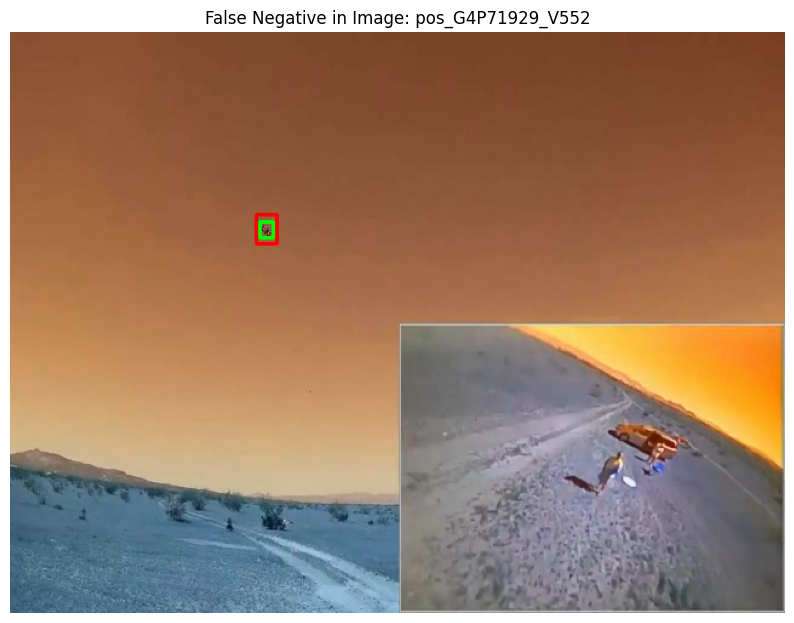

IoU values: []


In [17]:
import cv2
import matplotlib.pyplot as plt

def is_false_negative(image_name, ground_truths, detections, img_width, img_height, iou_threshold=0.5):
    """
    Determine if an image is a true or false negative. If false negative, display the image
    with predicted bounding boxes and ground truth bounding boxes. Print the IoU of the image.

    Args:
        image_name (str): Name of the image to evaluate.
        ground_truths (dict): Ground truth bounding boxes.
        detections (dict): Predicted bounding boxes.
        img_width (int): Image width.
        img_height (int): Image height.
        iou_threshold (float): IoU threshold for matching.

    Returns:
        bool: True if true negative, False if false negative.
    """
    gt_bboxes = ground_truths.get(image_name, [])
    pred_bboxes = detections.get(image_name, [])

    # Convert to xyxy format
    gt_boxes_xyxy = [yolo_to_xyxy(bbox, img_width, img_height) for bbox in gt_bboxes]
    pred_boxes_xyxy = list(set([tuple(yolo_to_xyxy(bbox, img_width, img_height)) for bbox in pred_bboxes]))
    
    matched_gt = set()
    ious = []
    for gt_box in gt_boxes_xyxy:
        match_found = False

        for pred_box in pred_boxes_xyxy:
            iou = calculate_iou(pred_box, gt_box)
            print(f"IoU value: {iou}")
            if iou >= iou_threshold:
                matched_gt.add(gt_box)
                match_found = True
                ious.append(iou)
                break

        if not match_found:
            # False negative detected
            print(f"False negative detected in image: {image_name}")
            display_image_with_bboxes(image_name, pred_boxes_xyxy, gt_boxes_xyxy, img_width, img_height)
            print(f"IoU values: {ious}")
            return False

    print(f"IoU values: {ious}")
    return True

def display_image_with_bboxes(image_name, pred_boxes, gt_boxes, img_width, img_height):
    """
    Display an image with predicted and ground truth bounding boxes.

    Args:
        image_name (str): Name of the image file.
        pred_boxes (list): Predicted bounding boxes in xyxy format.
        gt_boxes (list): Ground truth bounding boxes in xyxy format.
        img_width (int): Image width.
        img_height (int): Image height.
    """
    # Load the image
    image_path = f"test\\{image_name}.jpg"  
    image = cv2.imread(image_path)

    # Draw ground truth boxes in green
    for bbox in gt_boxes:
        x_min, y_min, x_max, y_max = map(int, bbox)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    # Draw predicted boxes in red
    for bbox in pred_boxes:
        x_min, y_min, x_max, y_max = map(int, bbox)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(f"False Negative in Image: {image_name}")
    plt.axis("off")
    plt.show()

# Example usage
image_name_to_check = "pos_G4P71929_V552"  # Replace with the image name from the above list
is_fn = is_false_negative(
    image_name_to_check, ground_truths, hs_pipeline_detections, img_width, img_height
)
if is_fn:
    print(f"Image {image_name_to_check} is a True Negative.")


## per image visualization of the pipeline

bounding boxes discovered by the HS anomaly detection

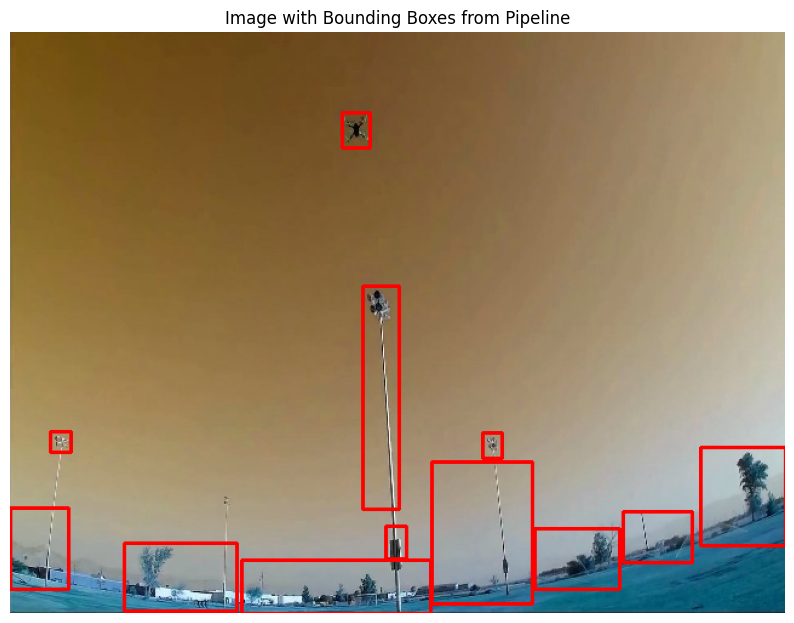

In [15]:
import cv2
import matplotlib.pyplot as plt
bb =[]
def run_pipeline_and_draw(image_path):
    """
    Run the anomaly detection pipeline on an image and display it with bounding boxes.

    Args:
        image_path (str): Path to the input image.

    Returns:
        None
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return


    try:
        # Run the anomaly detection pipeline
        bounding_boxes = detect_anomalies(image_path,max_area = 30000, numb_pca_components=2 )  # This should return bounding boxes in (x, y, w, h) format
        bb= bounding_boxes
    except Exception as e:
        print(f"Error running pipeline: {e}")
        return

    if not bounding_boxes:
        print("No bounding boxes returned by the pipeline.")
        return

    # Draw all bounding boxes on the image
    for bbox in bounding_boxes:
        x, y, w, h = map(int, bbox)
        cv2.rectangle(image, (x, y), (x + w, y + h), color=(255, 0, 0), thickness=2)  # Blue for all boxes

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Image with Bounding Boxes from Pipeline")
    plt.show()

# Example usage
image_path = r"test\pos_G3P50950.jpg"  # Replace with relevant image path
run_pipeline_and_draw(image_path)


visuelizing YOLO results for each detected BB

[[0.5, 393.5, 48.0, 67.0], [33.5, 330.5, 17.0, 17.0], [94.5, 422.5, 93.0, 56.0], [191.5, 436.5, 156.0, 44.0], [274.5, 67.5, 23.0, 29.0], [291.5, 210.5, 30.0, 184.0], [310.5, 408.5, 17.0, 27.0], [348.5, 355.5, 83.0, 117.0], [390.5, 331.5, 16.0, 21.0], [433.5, 410.5, 70.0, 50.0], [506.5, 396.5, 57.0, 42.0], [570.5, 343.5, 70.0, 81.0]]

0: 640x640 (no detections), 26.4ms
Speed: 2.0ms preprocess, 26.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results for ROI at (0, 343, 148, 137):
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: '0', 1: '1'}
obb: None
orig_img: array([[[174, 157, 124],
        [174, 157, 124],
        [174, 157, 124],
        ...,
        [166, 143, 105],
        [166, 143, 105],
        [166, 143, 105]],

       [[174, 157, 124],
        [174, 157, 124],
        [174, 157, 124],
        ...,
        [166, 143, 105],
        [166, 143, 105],
        [1

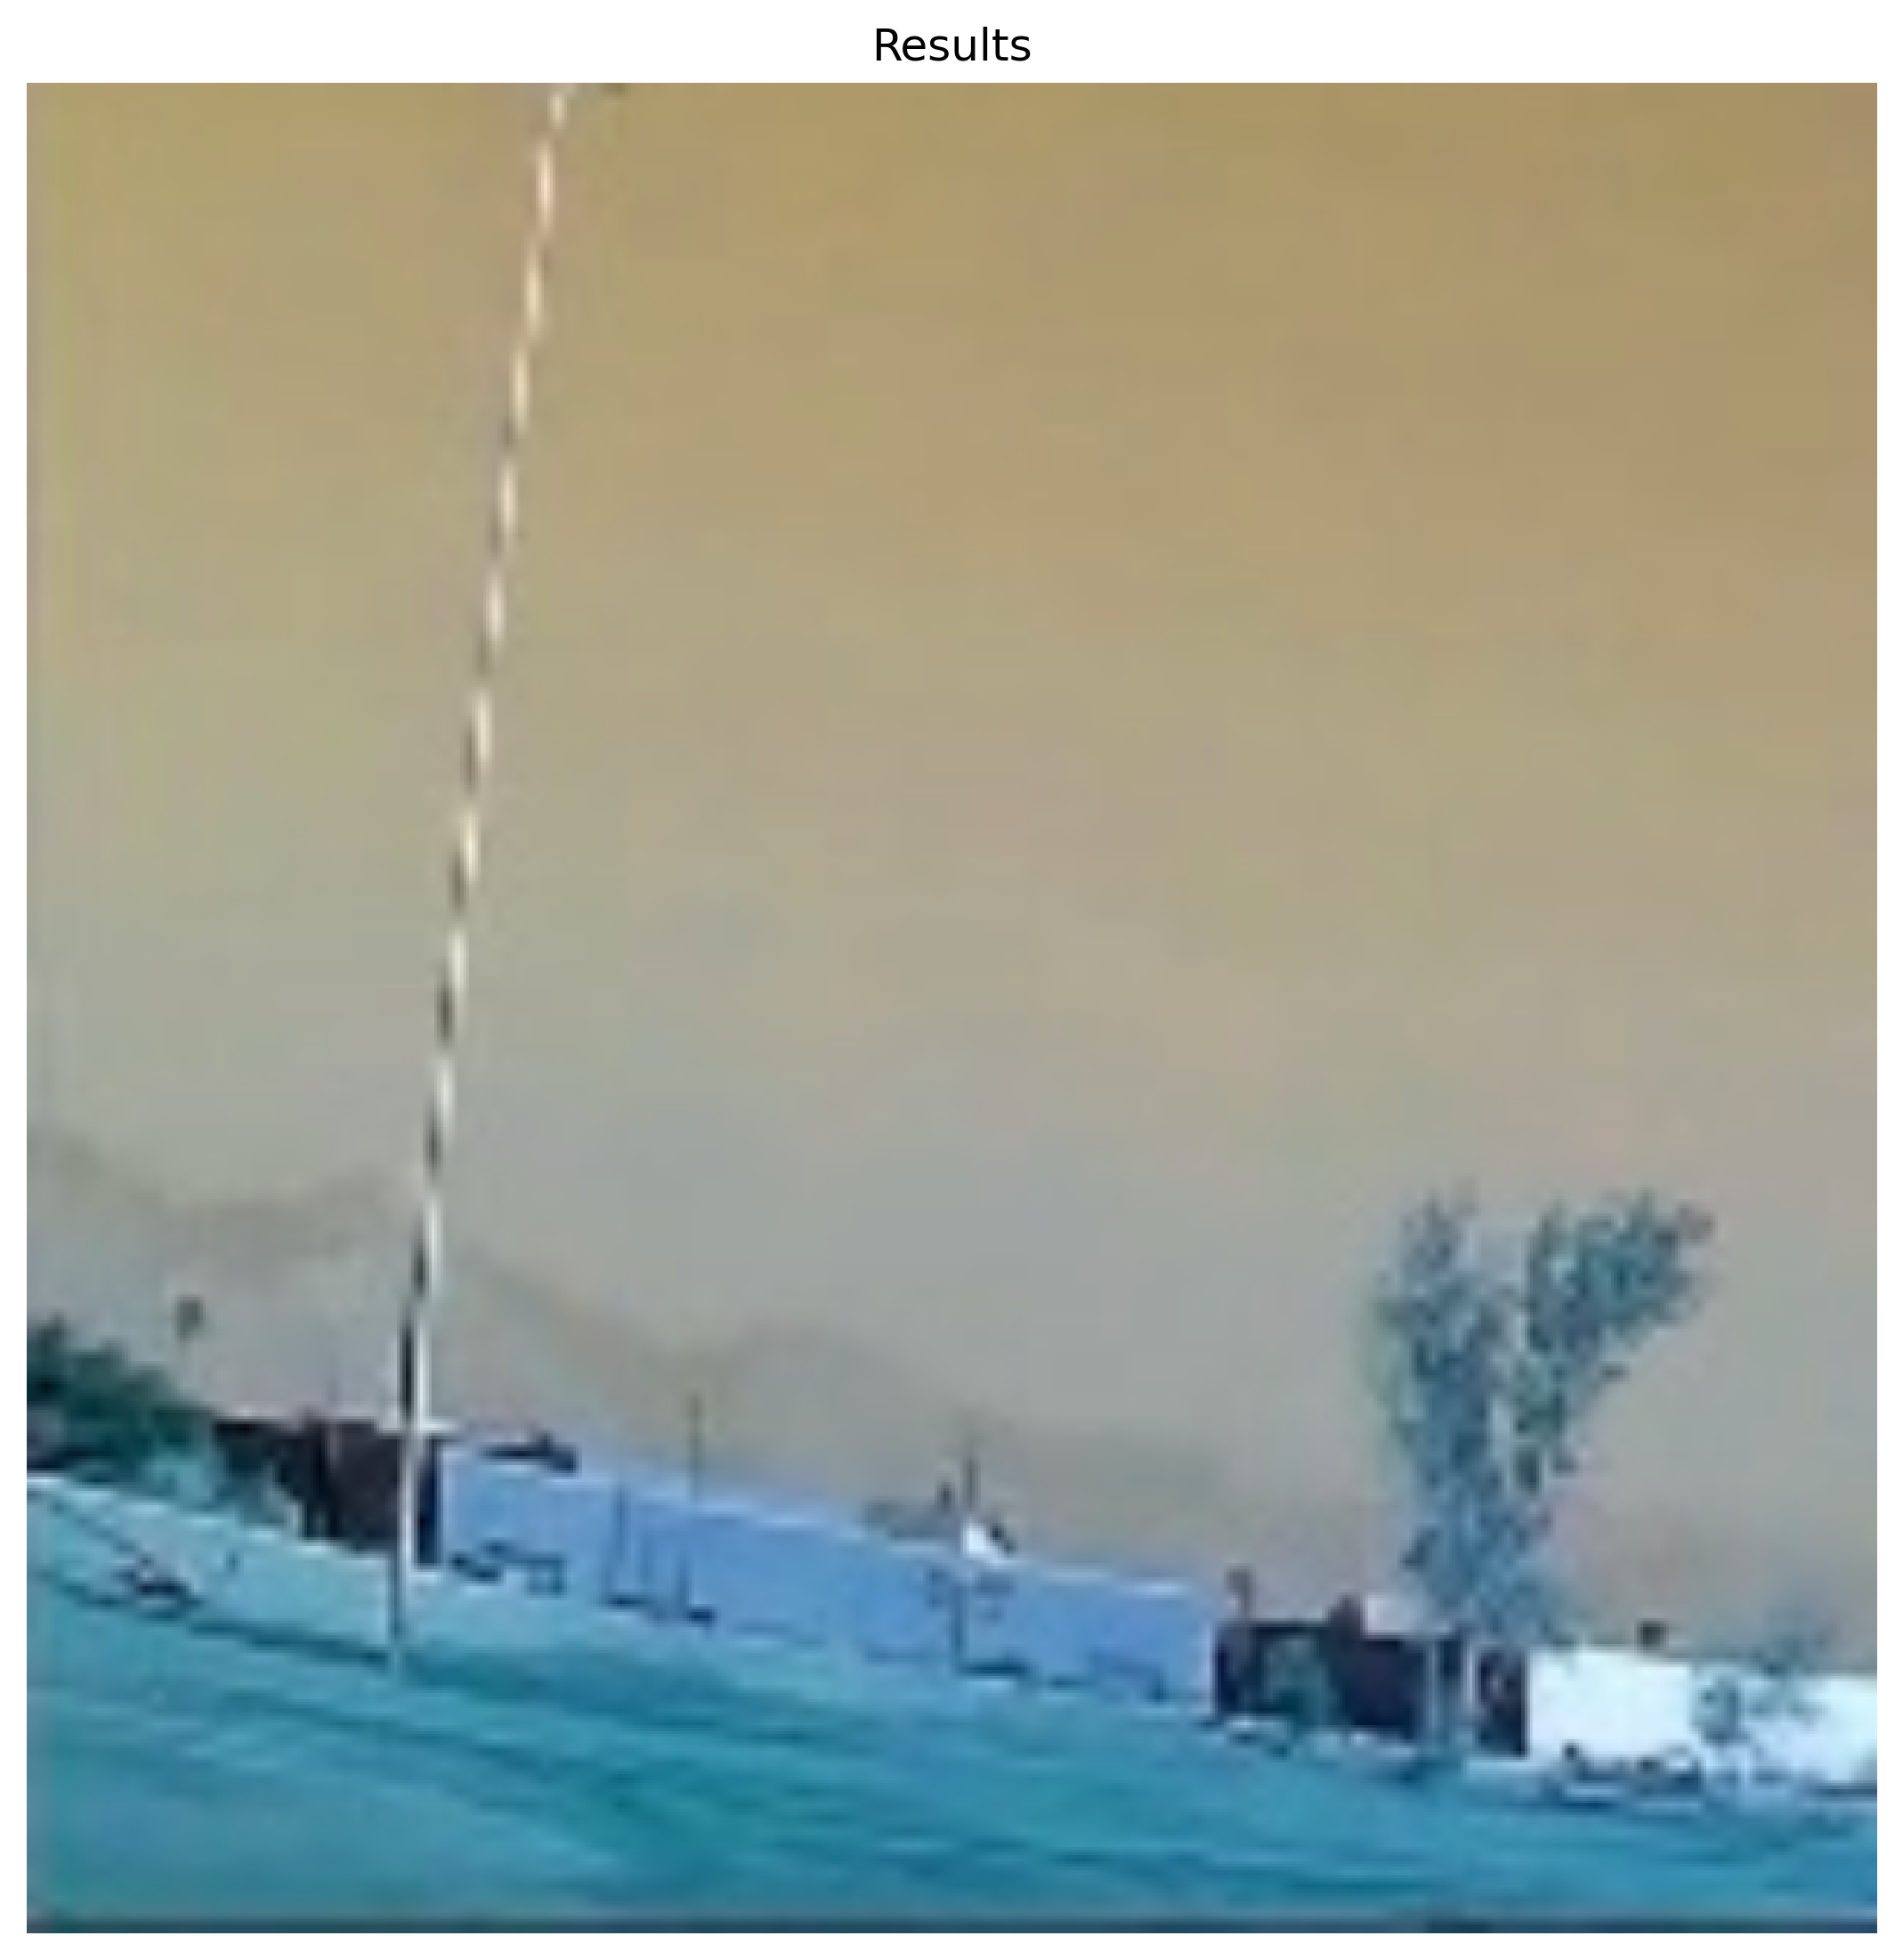


0: 640x640 (no detections), 21.9ms
Speed: 2.0ms preprocess, 21.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results for ROI at (0, 280, 117, 117):
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: '0', 1: '1'}
obb: None
orig_img: array([[[154, 131,  93],
        [154, 131,  93],
        [154, 131,  93],
        ...,
        [156, 127,  76],
        [156, 127,  76],
        [156, 127,  76]],

       [[154, 131,  93],
        [154, 131,  93],
        [154, 131,  93],
        ...,
        [156, 127,  76],
        [156, 127,  76],
        [156, 127,  76]],

       [[154, 131,  93],
        [154, 131,  93],
        [154, 131,  93],
        ...,
        [156, 127,  76],
        [156, 127,  76],
        [156, 127,  76]],

       ...,

       [[164, 164, 148],
        [164, 164, 148],
        [164, 164, 148],
        ...,
        [175, 164, 136],
        [175, 164, 136],
  

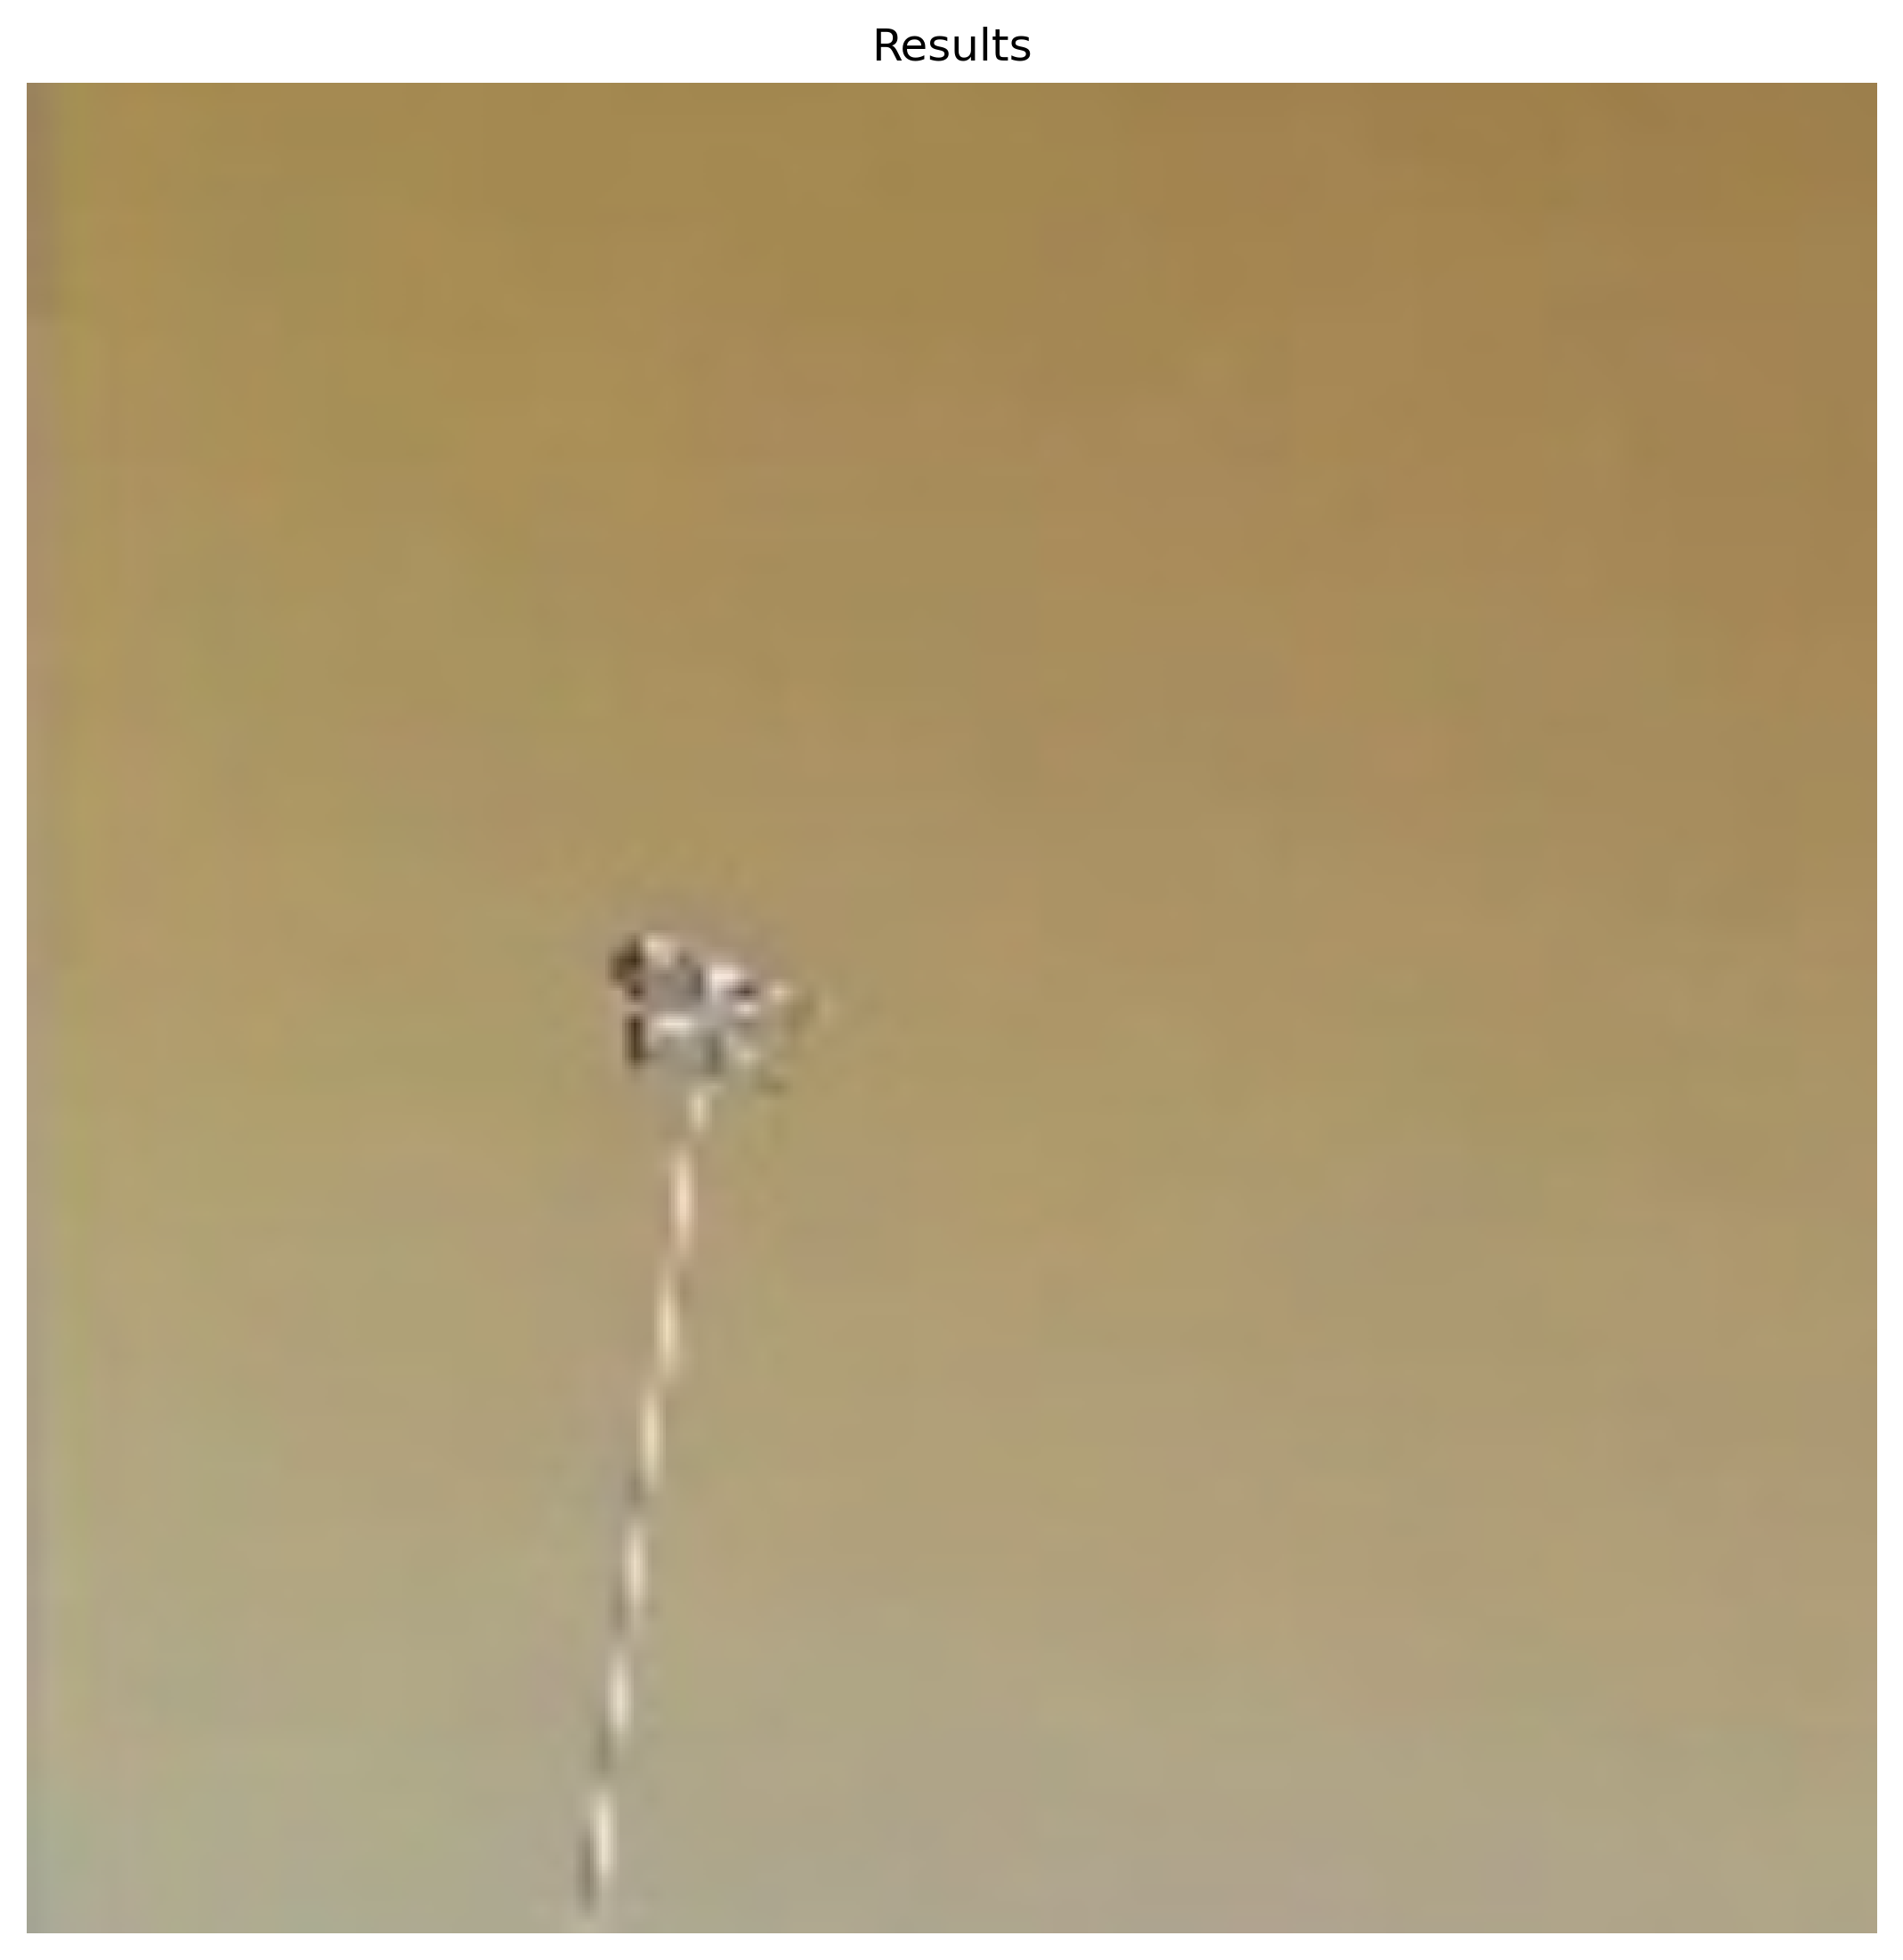


0: 640x640 1 0, 22.9ms
Speed: 2.0ms preprocess, 22.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results for ROI at (44, 160, 569, 320):
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: '0', 1: '1'}
obb: None
orig_img: array([[[137, 106,  43],
        [137, 106,  43],
        [138, 107,  44],
        ...,
        [186, 168, 137],
        [187, 169, 138],
        [187, 169, 140]],

       [[137, 106,  43],
        [137, 106,  43],
        [138, 107,  44],
        ...,
        [186, 168, 137],
        [187, 169, 138],
        [187, 169, 140]],

       [[137, 106,  43],
        [137, 106,  43],
        [138, 107,  44],
        ...,
        [187, 169, 138],
        [188, 170, 139],
        [187, 169, 140]],

       ...,

       [[ 73, 121, 143],
        [ 71, 120, 141],
        [ 69, 117, 139],
        ...,
        [ 22,  69,  91],
        [ 22,  69,  91],
        [ 22,

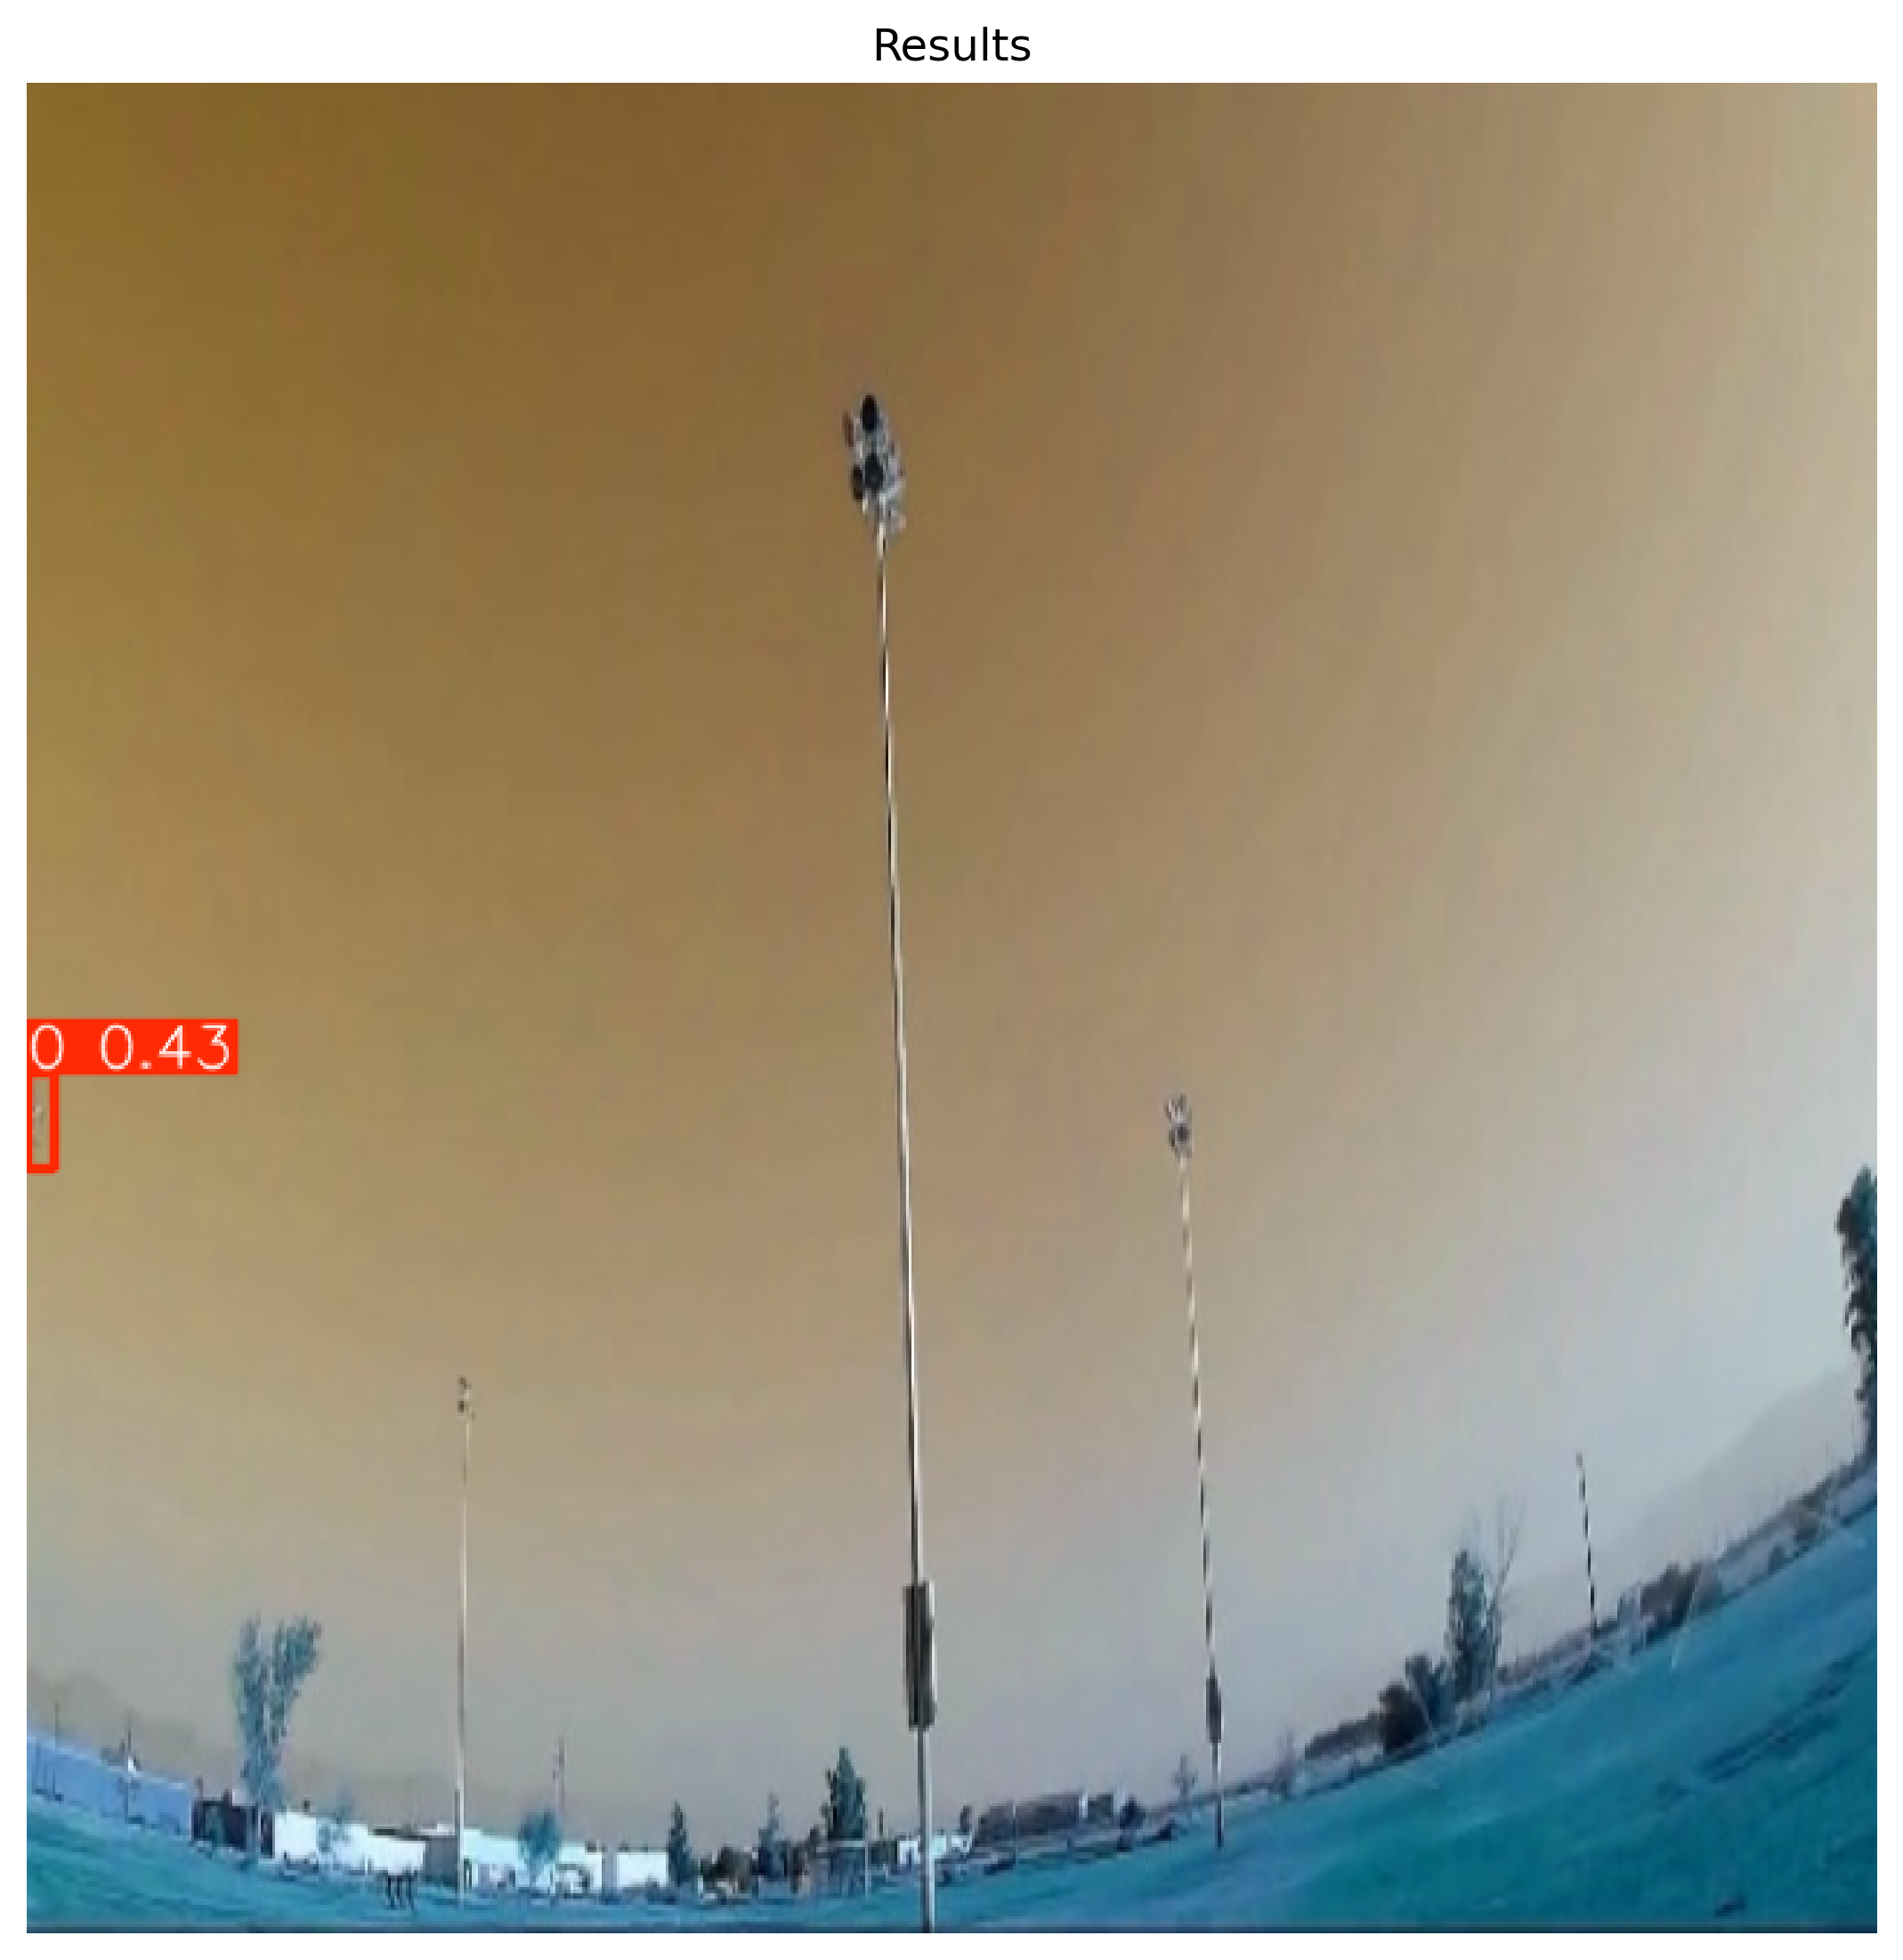


0: 640x640 1 0, 21.9ms
Speed: 2.0ms preprocess, 21.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results for ROI at (224, 17, 123, 129):
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: '0', 1: '1'}
obb: None
orig_img: array([[[108,  73,  29],
        [108,  73,  29],
        [108,  73,  29],
        ...,
        [117,  85,  42],
        [117,  85,  42],
        [117,  85,  42]],

       [[108,  73,  29],
        [108,  73,  29],
        [108,  73,  29],
        ...,
        [117,  85,  42],
        [117,  85,  42],
        [117,  85,  42]],

       [[108,  73,  29],
        [108,  73,  29],
        [108,  73,  29],
        ...,
        [117,  85,  42],
        [117,  85,  42],
        [117,  85,  42]],

       ...,

       [[125,  92,  43],
        [125,  92,  43],
        [125,  92,  43],
        ...,
        [131, 100,  55],
        [131, 100,  55],
        [131,

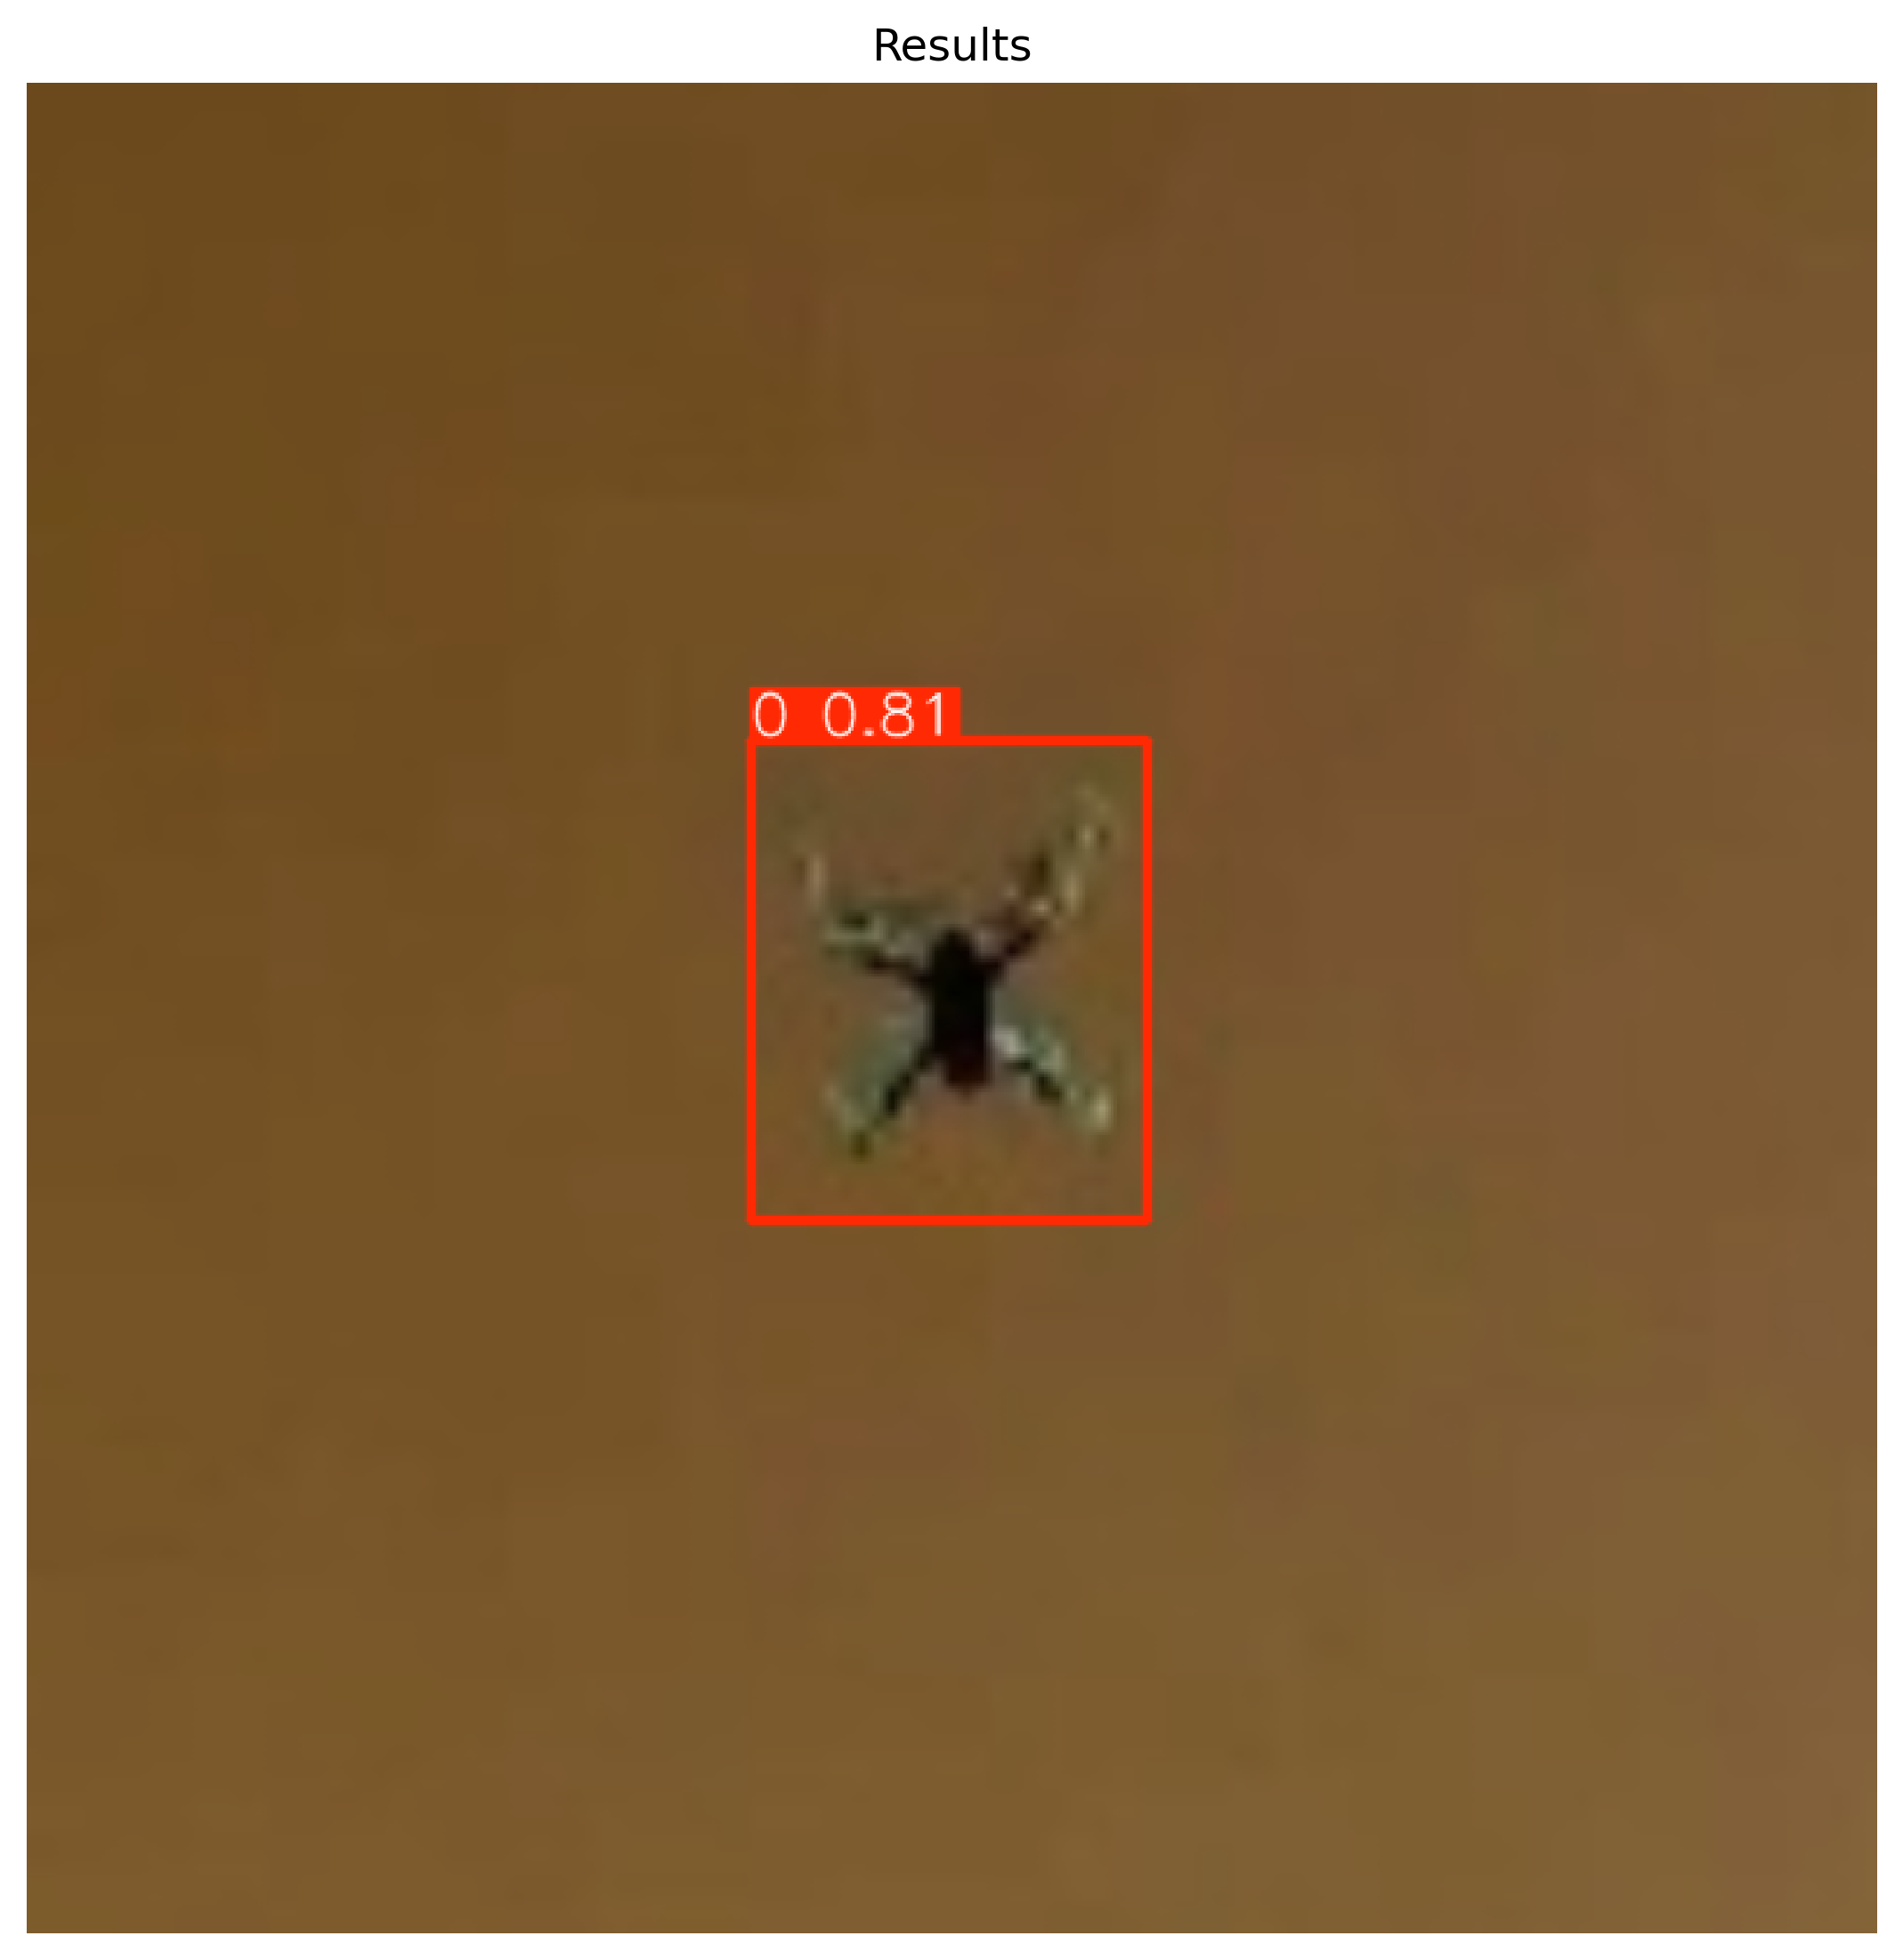


0: 640x640 (no detections), 21.9ms
Speed: 2.0ms preprocess, 21.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results for ROI at (520, 293, 120, 181):
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: '0', 1: '1'}
obb: None
orig_img: array([[[174, 165, 145],
        [174, 165, 145],
        [174, 165, 145],
        ...,
        [201, 198, 193],
        [201, 198, 193],
        [201, 198, 193]],

       [[174, 165, 145],
        [174, 165, 145],
        [174, 165, 145],
        ...,
        [201, 198, 193],
        [201, 198, 193],
        [201, 198, 193]],

       [[174, 165, 145],
        [174, 165, 145],
        [174, 165, 145],
        ...,
        [201, 198, 194],
        [201, 198, 194],
        [201, 198, 194]],

       ...,

       [[  3,  93, 118],
        [  3,  93, 118],
        [  3,  93, 118],
        ...,
        [  5,  85, 109],
        [  5,  85, 109],


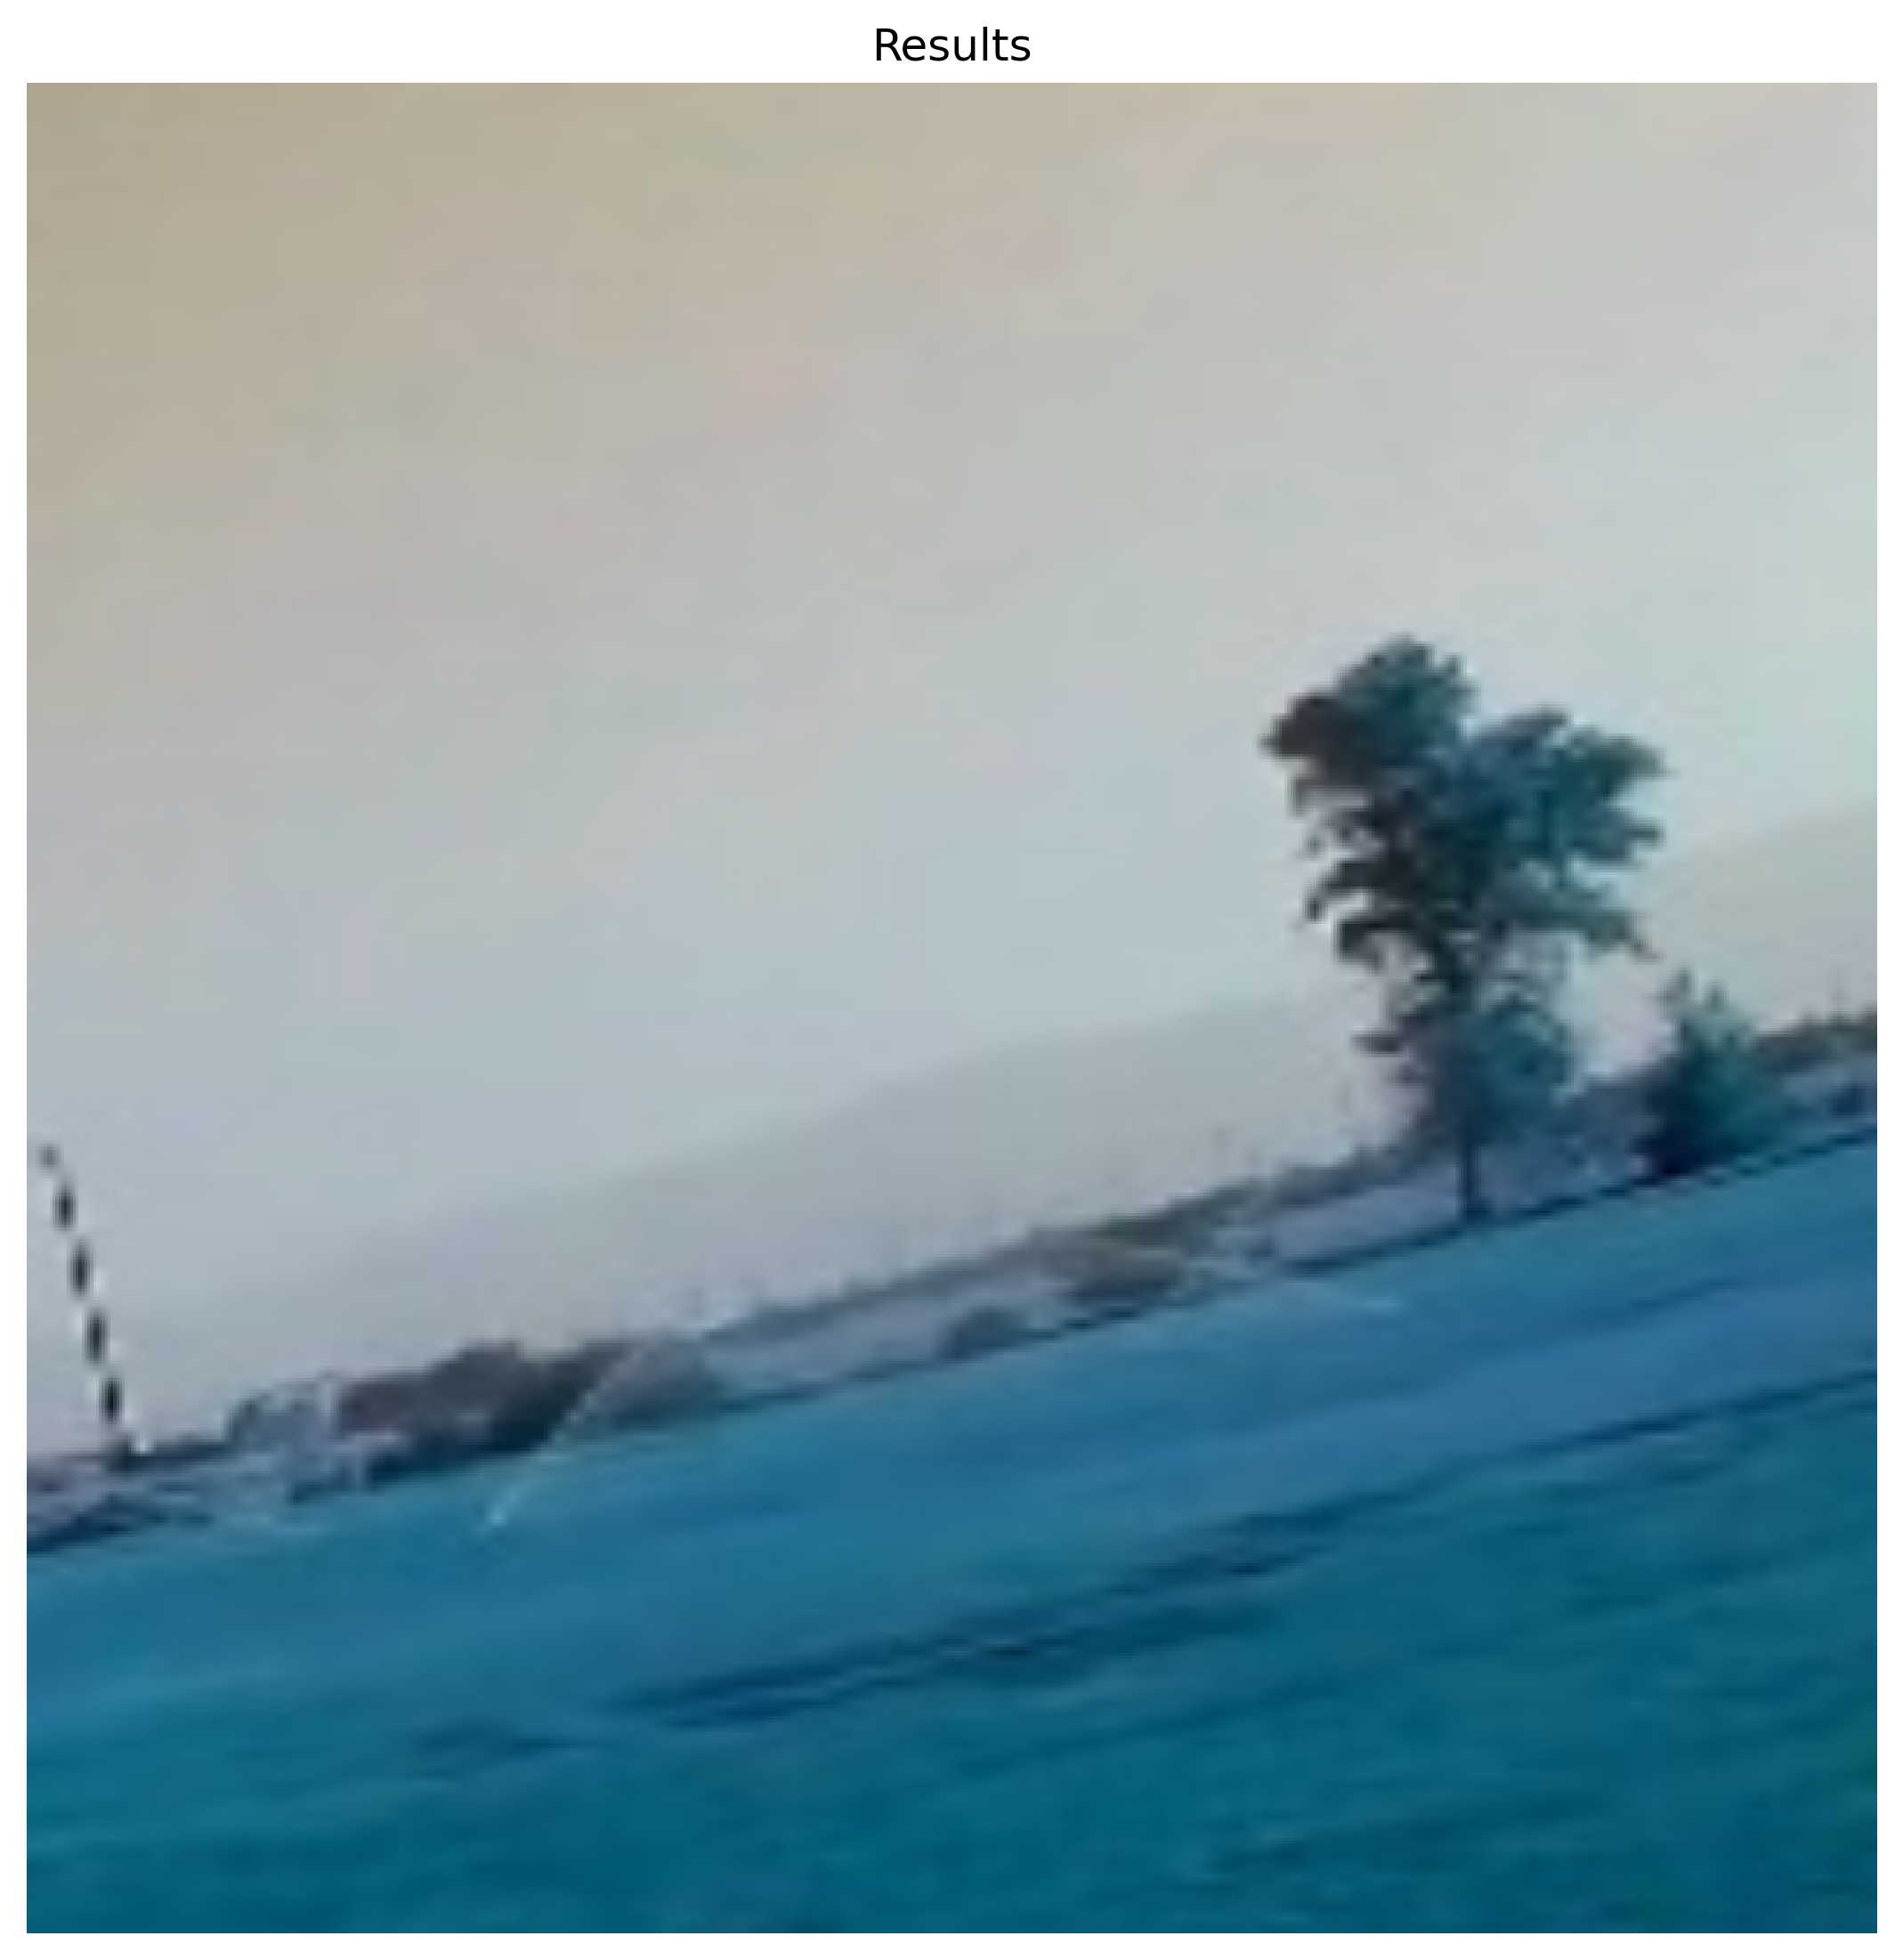

In [14]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths to the files
original_image_path = r"test\pos_G3P50950.jpg"  # Replace with relevant image path

# Load the original image
original_image = cv2.imread(original_image_path)


# Load  YOLO model
model = YOLO(r"yolov8m-drone.pt")

bounding_boxes = detect_anomalies(original_image_path,max_area = 30000, numb_pca_components=2,opts_lambda=0.4,ICA_max_iterations=1000 )  # parameter values can be changed to test different configurations
print(bounding_boxes) # for debugging purposes
merged_boxes = merge_bounding_boxes(bounding_boxes)
# Iterate over bounding boxes and run YOLO
for bbox in merged_boxes:
    x, y, w, h = map(int, bbox)

    # Add some padding to the bounding box for context (may need adjustment)
    padding = 50
    x = max(x - padding, 0)
    y = max(y - padding, 0)
    w = min(w + 2 * padding, original_image.shape[1] - x)
    h = min(h + 2 * padding, original_image.shape[0] - y)

    # Extract the ROI from the original image
    roi = original_image[y:y+h, x:x+w]

    # Resize the ROI to match YOLO's input size (e.g., 640x640)
    yolo_input_size = (640, 640)  
    roi_resized = cv2.resize(roi, yolo_input_size)

    # Feed the ROI to YOLO
    results = model.predict(roi_resized)

    # Print and show results for this ROI
    print(f"Results for ROI at ({x}, {y}, {w}, {h}):")
    print(results)  # Print detection results

    plt.figure(figsize=(16, 9), dpi=300)
    plt.title("Results")
    plt.imshow(results[0].plot())  # Plot predictions on the image
    plt.axis('off')
    plt.show()   

  

save an image after HS convertion - used for debugging / visualization

In [21]:
import scipy.io
import matlab.engine

# Start MATLAB engine
eng = matlab.engine.start_matlab()

image_path = r"test\images\1039.jpg"  # image path
rec_hs = eng.convertToHyperspectral(image_path,'hs_dictionaries.mat')

rec_hs_array = rec_hs  

# Save to .mat file
output_path = r"rec_hs_data.mat"  # output file name
scipy.io.savemat(output_path, {"rec_hs": rec_hs_array})

print(f"Hyperspectral data saved to {output_path}")


Hyperspectral data saved to C:\Users\michael\Desktop\f_proj\delete\rec_hs_data.mat
